# 主観評価実験A_2025年1月_岡田響生

In [1]:
# 参加者の名前
subject = "arakawa"

In [2]:
# 生成用の設定

import os
import math
import time

# カレントディレクトリをmagentaに
os.chdir(os.path.join(os.path.expanduser('~'), "GitHub\magenta"))

deg = 45
mag = 1
number_of_bars = 2
NUM_OUTPUTS = 6 # 初期個体の数

date = time.strftime('%Y-%m-%d')

SCRIPT_PATH = 'magenta\models\music_vae\music_vae_generate.py' # 実行したいスクリプトのファイル名
if number_of_bars == 2:
    MODEL_CONFIG = 'cat-mel_2bar_big'
elif number_of_bars == 16:
    MODEL_CONFIG = 'hierdec-mel_16bar'

CHECKPOINT_FILE = f'checkpoints\{MODEL_CONFIG}.tar' # チェックポイントファイルの場所
OUTPUT_DIR = 'tmp\music_vae\generated' # 基本となる出力場所
TEMPERATURE = 1e-4

valence = math.cos(math.radians(deg)) * mag
arousal = math.sin(math.radians(deg)) * mag

iec_dir = f'experiment\{subject}_iec_{MODEL_CONFIG}_{deg}_{mag}_{date}' # 今回のMIDIやベクトルを保存する場所

generation = 0 # 世代
midi_dir = os.path.join(OUTPUT_DIR, iec_dir, f"gen_{generation:03d}")
vectors_dir = os.path.join(OUTPUT_DIR, iec_dir, f"gen_{generation:03d}")

mo = f"checkpoints/attribute_vectors_{number_of_bars}bar_1129/mode.npy"
ap = f"checkpoints/attribute_vectors_{number_of_bars}bar_1129/average_pitch.npy"
nd = f"checkpoints/attribute_vectors_{number_of_bars}bar_1129/note_density.npy"
st = f"checkpoints/attribute_vectors_{number_of_bars}bar_1129/staccato_level.npy"
attribute_vectors = [ap, mo, nd, st]
vector_amounts = [0.8*valence, 0.2*valence, 0.8*arousal, 0.2*arousal]

# スクリプトに渡したい引数のリスト
args = [
    f'--config={MODEL_CONFIG}',
    f'--checkpoint_file={CHECKPOINT_FILE}', 
    f'--mode=sample_withattr',
    f'--num_outputs={NUM_OUTPUTS}',
    f'--output_dir={midi_dir}',
    f'--temperature={TEMPERATURE}',
    f'--attribute_vectors={",".join(attribute_vectors)}',
    f'--vector_amounts={",".join(map(str, vector_amounts))}',
    f'--savez=True'
]

In [3]:
# GA 
# 単峰性正規分布交叉（UNDX）

import numpy as np

def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        q = A[:, i]
        for j in range(i):
            q = q - np.dot(Q[:, j], A[:, i]) * Q[:, j]
        Q[:, i] = q / np.linalg.norm(q)
    return Q

def distance_point_to_line(point1, point2, point3):
    line_vec = point2 - point1
    proj_vec = np.dot((point3 - point1), line_vec) / np.linalg.norm(line_vec)**2 * line_vec
    perp_vec = point3 - point1 - proj_vec
    distance = np.linalg.norm(perp_vec)
    return distance

def undx(parent1, parent2, parent3, sigma_xi=0.5, sigma_eta=0.35):
    n = parent1.size
    m = (parent1 + parent2) / 2.0
    d = parent2 - parent1
    D = distance_point_to_line(parent1, parent2, parent3)
    
    E = np.eye(n)
    d_norm = d / np.linalg.norm(d)
    E[:, 0] = d_norm
    Q = gram_schmidt(E)
    e = Q[:, 1:]

    xi = np.random.normal(0, sigma_xi)
    eta = np.random.normal(0, sigma_eta/np.sqrt(n), n-1)

    child = m + xi * d + D * np.dot(e, eta)
    return child

def undx2(parent1, parent2, parent3, sigma_xi=0.5, sigma_eta=0.35):
    n = parent1.size
    m = (parent1 + parent2) / 2.0
    d = parent2 - parent1
    D = distance_point_to_line(parent1, parent2, parent3)
    
    E = np.eye(n)
    d_norm = d / np.linalg.norm(d)
    E[:, 0] = d_norm
    Q = gram_schmidt(E)
    e = Q[:, 1:]

    xi = np.random.normal(0, sigma_xi)
    eta = np.random.normal(0, sigma_eta/np.sqrt(n), n-1)

    child1 = m + xi * d + D * np.dot(e, eta)
    child2 = m - xi * d - D * np.dot(e, eta)
    return child1, child2

In [4]:
# MIDI表示・再生UIのクラス

os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = '1'
import numpy as np
import os
from IPython.display import display, clear_output
import pretty_midi
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pygame
import threading
import time

class MusicEvolutionUI:
    def __init__(self, population_size, generation, midi_folder, number_of_bars):
        self.population_size = population_size
        self.generation = generation
        self.midi_folder = midi_folder
        self.population = self.get_midi_files()
        self.number_of_bars = number_of_bars
        self.currently_playing = None
        
        # Pygame mixerの初期化
        pygame.mixer.init()
        
        self.setup_ui()
        
    def get_midi_files(self):
        files = [f for f in os.listdir(self.midi_folder) if f.endswith('.mid')]
        return files[:self.population_size]
    
    def setup_ui(self):
        self.buttons = []
        self.output = widgets.Output()
        
        # 再生/停止ボタンの生成
        for i in range(self.population_size):
            btn = widgets.Button(description=f'Play {i+1}')
            btn.on_click(lambda b, i=i: self.on_selection(i))
            self.buttons.append(btn)
            
        # self.next_gen_btn = widgets.Button(description='Next Generation')
        # self.next_gen_btn.on_click(self.create_next_generation)
        
        self.display_population()
        
    def display_population(self):
        """6つのピアノロールとボタンを表示"""
        with self.output:
            clear_output(wait=True)
            fig, axes = plt.subplots(2, 3, figsize=(15, 6))
            axes = axes.ravel()
            
            for i, midi_file in enumerate(self.population):
                file_path = os.path.join(self.midi_folder, midi_file)
                self.plot_midi(file_path, axes[i], i+1)
                
            plt.tight_layout()
            plt.show()
            
            for i in range(0, 6, 3):
                display(widgets.HBox(self.buttons[i:i+3]))
            # display(self.next_gen_btn)
    
    def plot_midi(self, file_path, ax, index):
        """ピアノロール描画部分"""
        try:
            midi = pretty_midi.PrettyMIDI(file_path)
            if midi.instruments:
                notes = midi.instruments[0].notes
                
            for note in notes:
                ax.add_patch(plt.Rectangle(
                    (midi.time_to_tick(note.start)/4.4, note.pitch),
                    midi.time_to_tick(note.get_duration())/4.4, 1,
                    fc="violet", ec="k", lw=0.5))
            
            ax.set_ylabel('Pitch')
            ax.set_xlabel('Time')
            ax.invert_yaxis()
            ax.set_xlim(0, self.number_of_bars*200)
            ax.set_ylim(12, 108)
            ax.set_xticks(np.arange(0, self.number_of_bars*200, self.number_of_bars*200/8))
            ax.set_xticklabels(np.arange(0, self.number_of_bars*2, self.number_of_bars*2/8))
            ax.set_yticks(np.arange(12, 108, 12))
            ax.set_yticklabels([f"C{i}" for i in range(0, 8)])
            ax.grid(alpha=0.25)
            ax.set_title(f'Individual {index}')
            
        except Exception as e:
            print(f"Failed to plot {file_path}: {e}")
    
    def play_midi(self, file_path):
        """末尾に休符を追加したMIDI一時ファイルを作成・再生"""
        try:
            # MIDIファイルを読み込み
            midi_data = pretty_midi.PrettyMIDI(file_path)
            if not midi_data.instruments:
                return
                
            notes = midi_data.instruments[0].notes
            if not notes:
                return
                
            # 最後のノートの終了時間を取得
            last_note_end = notes[-1].end
            
            # 休符を追加（0.5秒分）
            silence_duration = 0.5
            silence_note = pretty_midi.Note(
                velocity=0,  # ベロシティを0に設定
                pitch=notes[-1].pitch,  # 最後のノートと同じピッチ
                start=last_note_end,
                end=last_note_end + silence_duration
            )
            midi_data.instruments[0].notes.append(silence_note)
            
            # 一時ファイルとして保存
            temp_path = file_path.replace('.mid', '_temp.mid')
            midi_data.write(temp_path)
            
            if self.currently_playing:
                pygame.mixer.music.stop()
                self.currently_playing = None
                time.sleep(0.1)
            
            pygame.mixer.music.load(temp_path)
            pygame.mixer.music.play()
            self.currently_playing = file_path
            
            # 再生終了を監視するスレッド
            def check_music_end():
                while pygame.mixer.music.get_busy():
                    time.sleep(0.1)
                self.currently_playing = None
                # すべてのボタンをPlayに戻す
                for i, btn in enumerate(self.buttons):
                    btn.description = f'Play {i+1}'
                # 一時ファイルを削除
                if os.path.exists(temp_path):
                    os.remove(temp_path)
            
            threading.Thread(target=check_music_end, daemon=True).start()
                
        except Exception as e:
            print(f"Failed to play {file_path}: {e}")

    
    def on_selection(self, index):
        """MIDIファイルの再生/停止の切り替え"""
        file_path = os.path.join(self.midi_folder, self.population[index])
        
        if self.currently_playing == file_path:
            # 現在再生中の曲なら停止
            pygame.mixer.music.stop()
            self.currently_playing = None
            self.buttons[index].description = f'Play {index+1}'
        else:
            # 新しい曲を再生
            self.play_midi(file_path)
            
            # すべてのボタンをPlayに戻す
            for i, btn in enumerate(self.buttons):
                btn.description = f'Play {i+1}'
            
            # 選択されたボタンをStopに変更
            self.buttons[index].description = f'Stop {index+1}'
        
    def create_next_generation(self, _):
        self.generation += 1
        self.display_population()
    
    def __del__(self):
        """クリーンアップ処理"""
        pygame.mixer.quit()


# 親選択UI

import ipywidgets as widgets
from IPython.display import display

# 利用可能な親個体の番号リストを作成
available_parents = list(range(1, NUM_OUTPUTS+1))  # 0からlen-1までの数字

# ラジオボタンウィジェットの作成
parent1_radio = widgets.RadioButtons(
    options=available_parents,
    value=None,
    description='1st:',
    style={'description_width': 'initial'}
)

parent2_radio = widgets.RadioButtons(
    options=available_parents,
    value=None,
    description='2nd:',
    style={'description_width': 'initial'}
)

parent3_radio = widgets.RadioButtons(
    options=available_parents,
    value=None,
    description='3rd:',
    style={'description_width': 'initial'}
)

# 選択値を取得する関数
def get_selected_parents():
    return parent1_radio.value-1, parent2_radio.value-1, parent3_radio.value-1

def get_no1():
    return parent1_radio.value-1

In [5]:
# 初期世代生成

import subprocess

print("生成中...完了まで30秒ほどかかります")
result = subprocess.run(['python', SCRIPT_PATH] + args, cwd=os.getcwd(), capture_output=True, text=True)
print("初期世代生成完了")

生成中...完了まで30秒ほどかかります
初期世代生成完了


In [ ]:
# 参加者の名前を入力したら、このセルを選択して、
# 「上記のセルで実行」をクリックしてください。

## 実験
1. 「メロディを表示する」セルを実行する
2. Play 1 ~ Play 6 のボタンをクリックしてメロディを再生する
3. 「陽気(Cheerful)」や「興奮(Excited)」を表現していて、かつ質の良いメロディを、良い順に3つ選択する
4. 「次の世代に進む」セルを実行し、「第○世代生成完了」と表示されるまで待つ
5. 1. ~ 4. を3回繰り返す
6. 「メロディを表示する」セルを実行し、セル上部に「現在、第3世代です」と表示されるのを確認する
7. 最も良いメロディを1stで選択して、「最終出力」セルを実行する

In [14]:
# メロディを表示する

print(f"現在、第{generation}世代です")

evolution_ui = MusicEvolutionUI(population_size=NUM_OUTPUTS,
                                generation=generation,
                                midi_folder=midi_dir,
                                number_of_bars=number_of_bars)
display(evolution_ui.output)

parent1_radio.value = parent2_radio.value = parent3_radio.value = None

# 選択ウィジェットの表示
display(widgets.HBox([parent1_radio, parent2_radio, parent3_radio]))

現在、第4世代です


Output()

In [ ]:
# 次の世代に進む

import glob
import numpy as np
import os
import random

# 親個体の重複チェックを行う関数
def check_duplicate_parents(parent1, parent2, parent3):
    parents = [parent1, parent2, parent3]
    return len(set(parents)) != len(parents)

parent1_num, parent2_num, parent3_num = get_selected_parents()

# 重複チェック
if check_duplicate_parents(parent1_num, parent2_num, parent3_num):
    raise Exception("選択した個体に重複があります") 

npy_paths = glob.glob(os.path.join(vectors_dir, '*.npy'))
arrays = [np.load(file) for file in npy_paths]
children = []

print(f"生成中...完了まで30秒ほどかかります")

# アルゴリズムの実行
# エリート選択で残す
children.append(arrays[parent1_num])
children.append(arrays[parent2_num])

# # UNDXによる次世代の生成
# children.append(undx(arrays[parent1_num],
#                      arrays[parent2_num],
#                      arrays[parent3_num]))
# children.append(undx(arrays[parent1_num],
#                      arrays[parent2_num],
#                      arrays[parent3_num]))
# children.append(undx(arrays[parent1_num],
#                      arrays[parent2_num],
#                      arrays[parent3_num]))

# UNDX2による次世代の生成
c1, c2 = undx2(arrays[parent1_num], arrays[parent2_num], arrays[parent3_num])
children.append(c1)
children.append(c2)

attribute_array = np.dot(np.stack([np.load(vector) for vector in attribute_vectors]).T, vector_amounts)

# 突然変異
children.append(np.random.randn(512) + attribute_array)
children.append(np.random.randn(512) + attribute_array)

# 生成処理

children_shuffled = random.sample(children, len(children))
generation += 1
midi_dir = os.path.join(OUTPUT_DIR, iec_dir, f"gen_{generation:03d}")
vectors_dir = os.path.join(OUTPUT_DIR, iec_dir, f"gen_{generation:03d}")
os.makedirs(vectors_dir)

for i in range(len(children_shuffled)):
    np.save(os.path.join(vectors_dir, f'{i+1:02d}.npy'), children_shuffled[i])

# スクリプトに渡したい引数のリスト
args = [
    '--config='+MODEL_CONFIG,
    '--checkpoint_file='+CHECKPOINT_FILE,
    '--mode=vectors',
    '--vectors_dir='+vectors_dir,
    '--output_dir='+midi_dir,
    '--temperature='+str(TEMPERATURE)
]

# subprocess.runを使用してスクリプトを実行
# 引数はリストの形で渡す
result = subprocess.run(['python', SCRIPT_PATH] + args, cwd=os.getcwd(), capture_output=True, text=True)

print(f"第{generation}世代生成完了")

生成中...完了まで30秒ほどかかります
第4世代生成完了


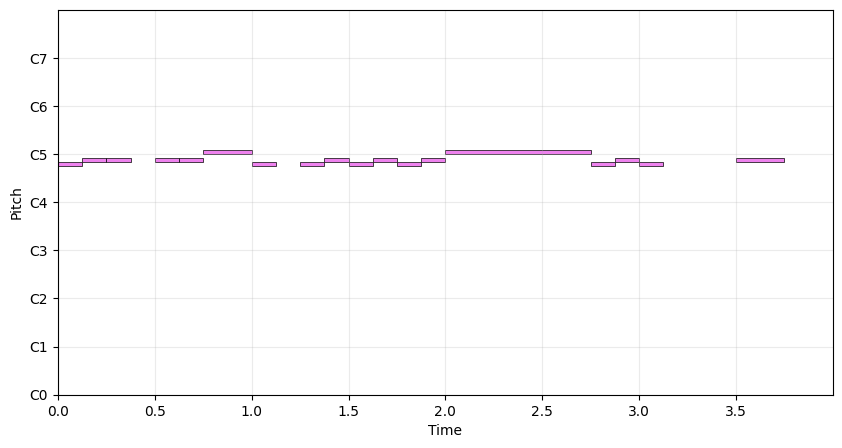

Button(description='Play', style=ButtonStyle())

In [15]:
# 最終出力

def play_midi(file_path):
    """末尾に休符を追加したMIDI一時ファイルを作成・再生"""
    try:
        # MIDIファイルを読み込み
        midi_data = pretty_midi.PrettyMIDI(file_path)
        if not midi_data.instruments:
            return
            
        notes = midi_data.instruments[0].notes
        if not notes:
            return
            
        # 最後のノートの終了時間を取得
        last_note_end = notes[-1].end
        
        # 休符を追加（0.5秒分）
        silence_duration = 0.5
        silence_note = pretty_midi.Note(
            velocity=0,  # ベロシティを0に設定
            pitch=notes[-1].pitch,  # 最後のノートと同じピッチ
            start=last_note_end,
            end=last_note_end + silence_duration
        )
        midi_data.instruments[0].notes.append(silence_note)
        
        # 一時ファイルとして保存
        temp_path = file_path.replace('.mid', '_temp.mid')
        midi_data.write(temp_path)
        
        pygame.mixer.music.load(temp_path)
        pygame.mixer.music.play()
        
        os.remove(temp_path)
            
    except Exception as e:
        print(f"Failed to play {file_path}: {e}")

parent1_num = get_no1()

midi_paths = glob.glob(os.path.join(midi_dir, '*.mid'))
result_midi_path = midi_paths[parent1_num]

# 描画関連
midi = pretty_midi.PrettyMIDI(result_midi_path)
if midi.instruments:
    notes = midi.instruments[0].notes
plt.figure(figsize=(10, 5))  # 図のサイズを設定（幅、高さ）

for note in notes:
    plt.gca().add_patch(plt.Rectangle(
        (midi.time_to_tick(note.start)/4.4, note.pitch), 
            midi.time_to_tick(note.get_duration())/4.4, 1, fc="violet", ec="k", lw=0.5))

plt.ylabel('Pitch')
plt.xlabel('Time')
plt.gca().invert_yaxis() # y軸反転
plt.xlim(0, number_of_bars*200)
plt.ylim(12, 108)
plt.xticks(np.arange(0, number_of_bars*200, number_of_bars*200/8), np.arange(0, number_of_bars*2, number_of_bars*2/8))
plt.yticks(np.arange(12, 108, 12), [f"C{i}" for i in range(0, 8)])
plt.grid(alpha=0.25)
plt.show()

# クリックハンドラー関数を定義
def on_button_clicked(b):
    play_midi(result_midi_path)

# ボタンを作成してクリックハンドラーを設定
btn = widgets.Button(description='Play')
btn.on_click(on_button_clicked)
display(btn)